## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join([sent.lower() for sent in text])

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [4]:
text = [part + "|" for part in text.split('\n\n')[::2]]

tokens = sorted(set(''.join(text)))
print("Количество токенов:", len(tokens))
print(text[:3])

Количество токенов: 39
["  from fairest creatures we desire increase,\n  that thereby beauty's rose might never die,\n  but as the riper should by time decease,\n  his tender heir might bear his memory:\n  but thou, contracted to thine own bright eyes,\n  feed'st thy light's flame with self-substantial fuel,\n  making a famine where abundance lies,\n  thy self thy foe, to thy sweet self too cruel:\n  thou that art now the world's fresh ornament,\n  and only herald to the gaudy spring,\n  within thine own bud buriest thy content,\n  and tender churl mak'st waste in niggarding:\n    pity the world, or else this glutton be,\n    to eat the world's due, by the grave and thee.|", "  when forty winters shall besiege thy brow,\n  and dig deep trenches in thy beauty's field,\n  thy youth's proud livery so gazed on now,\n  will be a tatter'd weed of small worth held:\n  then being asked, where all thy beauty lies,\n  where all the treasure of thy lusty days;\n  to say, within thine own deep sun

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
# dict <index>:<char>
# Your great code here
idx_to_token = {idx: token for idx, token in enumerate(tokens)}
# dict <char>:<index>
# Your great code here
token_to_idx = {value: key for key, value in idx_to_token.items()}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [6]:
# Your code here
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [7]:
class Poems(Dataset):
    def __init__(self, poems):
        self.poems = poems
    
    def __len__(self):
        return len(self.poems)
    
    def __getitem__(self, idx):
        return self.poems[idx]


poems = Poems(text)

In [8]:
class CharRNNCell(nn.Module):
    def __init__(self, num_tokens, emb_size=64, rnn_num_units=256):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.Linear(emb_size + rnn_num_units, rnn_num_units)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        x_emb = self.emb(x)
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = self.rnn(x_and_h)
        
        next_logits = self.hid_to_logits(h_next)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return h_next, next_logp

    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)
    
    
def rnn_loop(char_rnn, batch_ix, device):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size).to(device)
    logprobs = []

    for x_t in batch_ix.transpose(0, 1):
        hid_state, logp_next = char_rnn(x_t, hid_state)
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)


def to_matrix(sentences, token_to_idx, max_len=None, dtype='int32', batch_first=True):
    """Casts a list of sentences into rnn-digestable matrix"""
    
    pad = token_to_idx[' ']
    
    max_len = max_len or max(map(len, sentences))
    sentences_ix = np.zeros([len(sentences), max_len], dtype) + pad

    for i in range(len(sentences)):
        line_ix = [token_to_idx[c] for c in sentences[i]]
        sentences_ix[i, :len(line_ix)] = line_ix[:max_len]
        
    if not batch_first:
        sentences_ix = np.transpose(sentences_ix)

    return sentences_ix

Plot the loss function (axis X: number of epochs, axis Y: loss function).

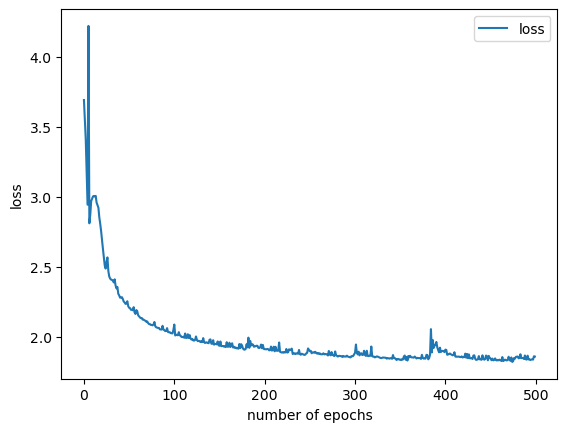

training...: 100%|███████████████████████████████████████████████████████████████████| 500/500 [02:06<00:00,  3.94it/s]


In [9]:
# Your plot code here
num_tokens = len(tokens)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch_size = 128
epochs = 500
char_rnn = CharRNNCell(num_tokens)
criterion = nn.NLLLoss()
opt = torch.optim.AdamW(char_rnn.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    opt, T_0=batch_size*epochs, eta_min=1e-7
)
char_rnn.train()
char_rnn.to(device)
history = []
poems_dataloader = DataLoader(
    poems, batch_size=batch_size, 
    num_workers=0, shuffle=True, 
    pin_memory=True, drop_last=True
)
for epoch in tqdm(range(epochs), total=epochs, desc="training..."):
    epoch_history = []
    for batch in poems_dataloader:
        opt.zero_grad()

        batch_ix = to_matrix(batch, token_to_idx, max_len=None)
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)

        logp_seq = rnn_loop(char_rnn, batch_ix, device)

        # compute loss
        predictions_logp = logp_seq[:, :-1]
        actual_next_tokens = batch_ix[:, 1:]

        loss = criterion(predictions_logp.contiguous().view(-1, num_tokens), 
                         actual_next_tokens.contiguous().view(-1))

        loss.backward()
        opt.step()
        scheduler.step()

        epoch_history.append(loss.cpu().data.numpy())

    history.append(np.mean(epoch_history))

    if (epoch + 1) % 10 == 0:        
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.xlabel("number of epochs")
        plt.ylabel("loss")
        plt.show()

In [10]:
def generate_sample(model, seed_phrase=' a', max_length=300, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = model.initial_state(batch_size=1)
    
    for i in range(len(seed_phrase) - 1):
        hid_state, out = model(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, out = model(x_sequence[:, -1], hid_state)
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
    
    return ''.join([idx_to_token[ix] for ix in x_sequence.data.numpy()[0]])

In [11]:
char_rnn.eval()
char_rnn.to("cpu")
temperature_params = [0.1, 0.2, 0.5, 1.0, 2.0]
for temperature in temperature_params:
    print(f"temperature = {temperature}")
    print(generate_sample(char_rnn, temperature=1.0))
    print("-" * 30)

temperature = 0.1
 ay ulis, no f o thaney choud did dimt hy blirg, me bed tonter ary sonking;
  terustrey,
  he  sall ge t s tid  xo  on teou wat d tha   lo me ti   an to n  whrt smy hou t on me the gr pury seave  to me thi g aken  ou t no co mt he oo!  ayot  nong ti h beacristoflo whis lame
  hardill ofros doverthes
------------------------------
temperature = 0.2
 ank
  whestifat weruco ha ind;
  for chaldect ling ind sape destot hy, art tr meld ghatr o m free bed tor hy sould lfaknet on  inve gh arey, ame dor alive 's par ee bor ais shich migs ace.
   ti e s  leve wly s ar with  hag twere tot pyot are hisesuptou'd,
  thee ceake thot bleit buiglorsacquitatty
------------------------------
temperature = 0.5
 arusand t'd;
  whthecendost frime?
  ay chares shas borushathyofllith.
  shrpeneree arthy?
  this tore,
  w il beaneystow thered, io tonatendisule bart.
  thot homese of owe-cand
  ayf-cr tif tren
  ambeene, so teerspos;
  and the pare be uly gave, so thee se co ne jure's fall t o

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [12]:
# Your beautiful code here
class LSTM(nn.Module):
    def __init__(
        self, 
        num_tokens, 
        emb_size=64, 
        rnn_num_units=256, 
        n_layers=1
    ):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.n_layers = n_layers
        
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.lstm = nn.LSTM(emb_size, rnn_num_units, n_layers, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, hidden):
        x_emb = self.emb(x)
        out, hidden = self.lstm(x_emb, hidden)
        next_logits = self.hid_to_logits(out)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hidden
    
    def initial_state(self, batch_size=1, device="cpu"):
        """ return rnn state before it processes first input (aka h0) """
        return (torch.zeros(self.n_layers, batch_size, self.num_units, requires_grad=True).to(device),
                torch.zeros(self.n_layers, batch_size, self.num_units, requires_grad=True).to(device))

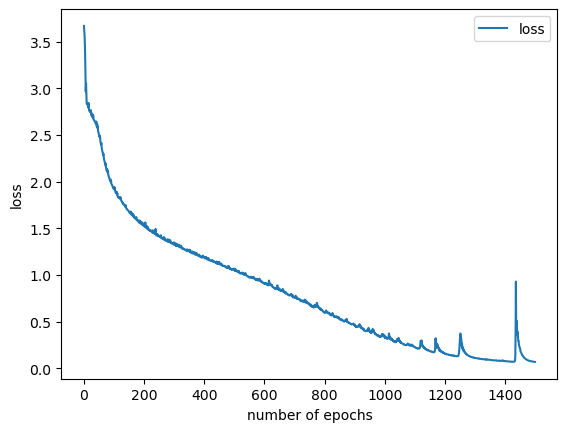

training...: 100%|█████████████████████████████████████████████████████████████████| 1500/1500 [09:11<00:00,  2.72it/s]


In [13]:
batch_size = 128
epochs = 1500
lstm_model = LSTM(num_tokens, n_layers=2)
lstm_model.train()
lstm_model.to(device)
criterion = nn.NLLLoss()
opt = torch.optim.AdamW(lstm_model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    opt, T_0=batch_size*epochs, eta_min=1e-7
)
poems_dataloader = DataLoader(
    poems, batch_size=batch_size, 
    num_workers=0, shuffle=True, 
    pin_memory=True, drop_last=True
)
history = []
for epoch in tqdm(range(epochs), total=epochs, desc="training..."):
    epoch_history = []
    for batch in poems_dataloader:
        opt.zero_grad()

        batch_ix = to_matrix(batch, token_to_idx, max_len=None)
        batch_ix = torch.tensor(batch_ix, dtype=torch.long).to(device)
        hidden = lstm_model.initial_state(batch_size, device)

        logp_seq, hidden = lstm_model(batch_ix, hidden)
        # compute loss
        loss = criterion(logp_seq[:, :-1].cpu().contiguous().view(-1, num_tokens), 
                         batch_ix[:, 1:].cpu().contiguous().view(-1))
        # train with backprop
        loss.backward()
        opt.step()
        scheduler.step()

        epoch_history.append(loss.data.numpy())

    history.append(np.mean(epoch_history))

    if (epoch + 1) % 10 == 0:        
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.xlabel("number of epochs")
        plt.ylabel("loss")
        plt.show()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [14]:
# Text generation with different temperature values here
def generate_sample_lstm(model, seed_phrase=' a', max_length=300, temperature=1.0):
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hidden = model.initial_state(1, "cpu")
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, hidden = model(x_sequence[:, i][None], hidden)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hidden = model(x_sequence[:, -1][None], hidden)
        # Be really careful here with the model output
        p_next = F.softmax(out[0] / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
    
    return ''.join([idx_to_token[ix] for ix in x_sequence.data.numpy()[0]])

In [15]:
lstm_model.eval()
lstm_model.to("cpu")
temperature_params = [0.1, 0.2, 0.5, 1.0, 2.0]
for temperature in temperature_params:
    print(f"temperature = {temperature}")
    print(generate_sample_lstm(lstm_model, temperature=1.0))
    print("-" * 30)

temperature = 0.1
 antherees, i make to skill,
  that thou basken, of no merithon ont.
  he laighs then theie, and summer's form thee;
    and see thy boy mades best endow'd witho
 -tratifle hath his chorn as might,
    and speak of enlot o'er inforly i'ply time,
  the pupish groan, and end user basessed
  to be thei
------------------------------
temperature = 0.2
 ah was swerplovers days bearly hold,
  nor are by thy mindness no better moak?
  o me shadow fried, and thought thee bright rochen,
  for let the dear still wi do but joy mysel,
  under that born for his guening no shame forse
  that due may me lives be two dearer
  and you your sad meary, be griev
------------------------------
temperature = 0.5
 antherees, in me away,
    i telling merk to the beauty stone,
  and ploud do i be dateleingn age;
  in old me to finge thy poor drudge;
  thou betdem mine eyes, and even i for dely.
    you shall lies were but sweeting come, do rone?|                                              

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [16]:
# Saving and loading code here
torch.save(lstm_model.state_dict(), 'LSTM_model.pt')
lstm_model.load_state_dict(torch.load('LSTM_model.pt'))

<All keys matched successfully>

In [17]:
lstm_model.eval()
lstm_model.to("cpu")
temperature_params = [0.1, 0.2, 0.5, 1.0, 2.0]
for temperature in temperature_params:
    print(f"temperature = {temperature}")
    print(generate_sample_lstm(lstm_model, seed_phrase=' ', temperature=1.0))
    print("-" * 30)

temperature = 0.1
  their poor rich pretty drong of thy weel;
  so shall those blessed far frew amindars
  where all heaven, your fool or times dit?
  the pen unnot bes, by tell deef in sind,
    learing eye's the charare; after loys' weri
  healt merit in my name's rich'd night,
    and to this perjur'd not to heal 
------------------------------
temperature = 0.2
  those lips that do both for a liques head
  which have now her woind this sourys to brhen,
  far yet tongue:
  i may by grains and of his pent,
  doth charge ther mort anaple of all thoughts,
  and pearfrain in her day with thee reneant.
  tise's tells my obow faith win doth lies that i call
    s
------------------------------
temperature = 0.5
  as a decrepy th seem-re nother stole
  to true here and cheekenes he tome born make,
  his ill vecance shall rie vight you hells,
  whilst may pelair, when how one coold-natel's,
  you's check me hour monant swounden's force lived,
  and tonguit'd fortune's wate our summer's deca

Vanilla RNN показала себя не очень. Я думаю это из-за того, что я использовал довольно длинные отрывки в качестве одного элемента батча, и из-за проблем с затухающим градиентом модель плохо справляется с данной задачей. Сгенерированный текст не напоминает даже обычную речь, не говоря о поэзии, хотя среди сгенерированного текста можно заметить знакомые слова.  
Используя LSTM удалось уменьшить loss примерно на 1.5. Сгенерированный текст уже похож на обычную речь (встречается довольно много английских слов, которые можно перевести), но лишен какого-либо смысла. Лучший (на мой взгляд) отрывок, который удалось сгенерировать: 
```
  ages are frow to have of thim:  
  a men the tongue, and thine orwards to cury,  
  and uncantrfacblest soull'd masted praise  
  to wang the world my heil when thou alone  
  and heavenly heart's recook my self not with  
  time humm and mine old tround for depill:  
  poorred to nightle pway youth feed weed,  
```

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)